In [1639]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import skew
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import norm


In [1640]:
# Load train and Test set
train = pd.read_csv("./train.csv")

In [1641]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))


# Save the 'Id' column
train_ID = train['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 

The train data size before dropping Id feature is : (1460, 81) 

The train data size after dropping Id feature is : (1460, 80) 


In [1642]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1643]:
# Getting Description
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Data visualizing and analyzing

Value of mean is : 180921.20
Value of Standard Deviation is: 79415.29


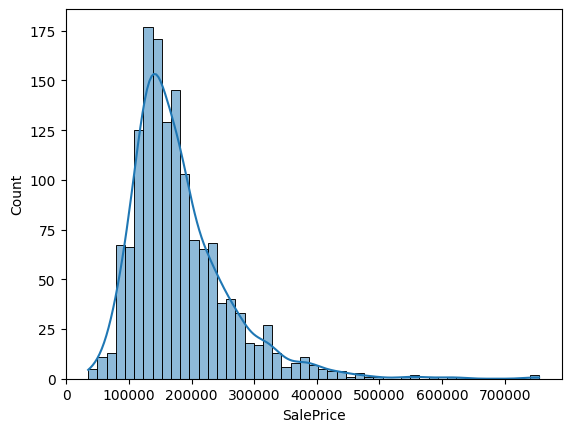

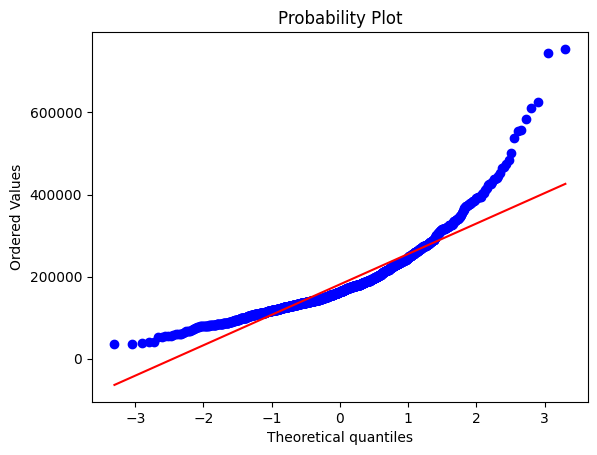

Skewness: 1.882876
Kurtosis: 6.536282


In [1644]:
# Plot Histogram to view distribution
distribution_graph = sns.histplot(data=train['SalePrice'], kde=True)
( mean, std ) = norm.fit(train['SalePrice']);
print("Value of mean is : {:.2f}".format(mean))
print("Value of Standard Deviation is: {:.2f}".format(std))

#Comparing the 'SalePrice' variable to a theoretical normal distribution 
# with a mean of zero and a standard deviation of one 
# is a common practice in statistics. 
# It allows us to assess whether the distribution of the variable is similar to a normal distribution, 
# which has several important properties that make it useful for statistical modeling. 
# If the distribution of the 'SalePrice' variable closely approximates a normal distribution, 
# it suggests that statistical models that assume normality may be appropriate for predicting house prices.
probability_graph = plt.figure() # create new figure
stats.probplot(train['SalePrice'],plot=plt) # generate probability plot
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [1645]:
print("Total columns of the dataset",len(train.columns));

# Checking Categorical Data
categorical_data = train.select_dtypes(include=['object']).columns
print("Number of categorical data: ",len(categorical_data));

# Checking Numerical Data
numerical_data = train.select_dtypes(include=['int64','float64']).columns
print("Number of numerical data: ",len(numerical_data));

Total columns of the dataset 80
Number of categorical data:  43
Number of numerical data:  37


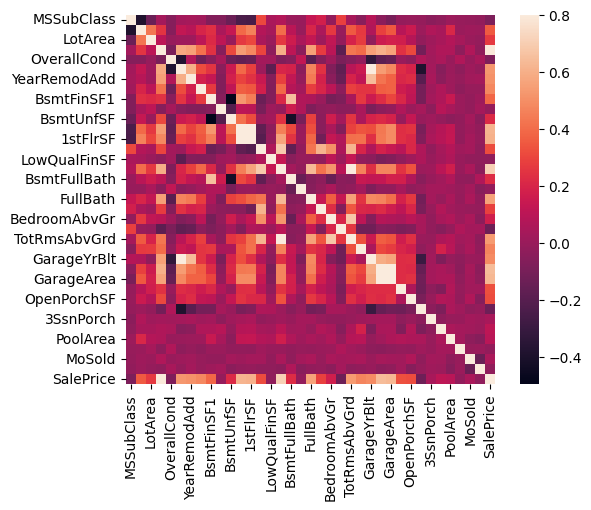

In [1646]:
# Correlation Matrix Heatmap
numerical_train = train[numerical_data]
corr_map = numerical_train.corr()
sns.heatmap(corr_map, vmax=.8, square=True);

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


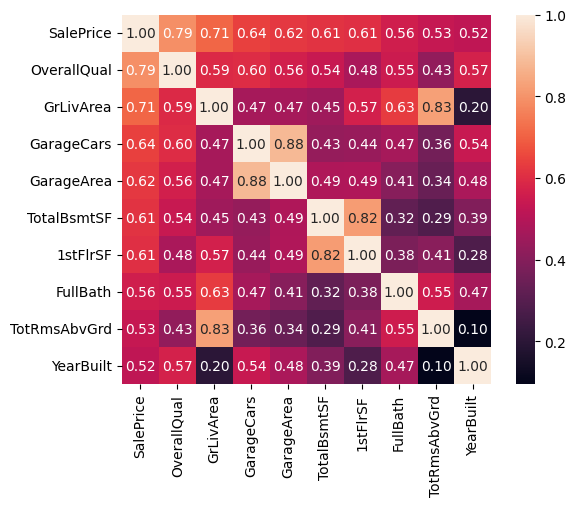

In [1647]:
# Top 10 Heatmap
feature_num = 10 #number of variables for heatmap
feature_column_data = corr_map.nlargest(feature_num, 'SalePrice')['SalePrice'];
feature_column = feature_column_data.index

# Table for 10 most correlated features order by descending
most_corr = pd.DataFrame(feature_column)
most_corr.columns = ['Most Correlated Features']
display(most_corr)

# Forming a new correlation matrix heatmap 
new_corr = numerical_train[feature_column].corr()
sns.heatmap(new_corr , annot=True , square=True , fmt='.2f') # "annot" gives the values for correlation and "fmt" formats data to be 2 decimal floating values
plt.show()

# Data pre-processing 

In [1648]:
# Overview of unique values in each selected column
for i in feature_column.tolist():
    print("Number of unique values in {} column are: {}".format(i,len(set(train[i]))))

Number of unique values in SalePrice column are: 663
Number of unique values in OverallQual column are: 10
Number of unique values in GrLivArea column are: 861
Number of unique values in GarageCars column are: 5
Number of unique values in GarageArea column are: 441
Number of unique values in TotalBsmtSF column are: 721
Number of unique values in 1stFlrSF column are: 753
Number of unique values in FullBath column are: 4
Number of unique values in TotRmsAbvGrd column are: 12
Number of unique values in YearBuilt column are: 112


After grasping the amount of data needs processing, we can now decide suitable types of graph for each feature.

Boxplot and scatterplot are the 2 main graphs used in this notebook.

Boxplot is suitable for numbers of "finite" values 
Scatterplot is suitable for numbers of "infinite" values 
- Boxplot       :   discrete data
- Scatterplot   :   continuous data

*** Age and Year are special cases ***

### Boxplots 

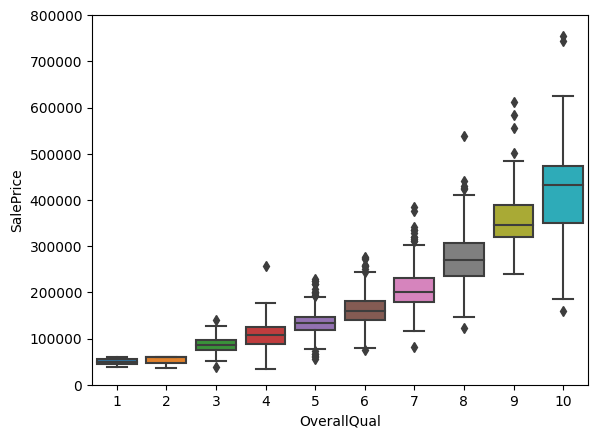

In [1649]:
# Overall Quality vs Sale Price
# Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)
overallqual_data = pd.concat([train['SalePrice'], train["OverallQual"]], axis=1)
overallqual_data_graph = sns.boxplot(x="OverallQual", y="SalePrice", data=overallqual_data)
overallqual_data_graph.axis(ymin=0, ymax=800000);

It is obvious that the better the quality of the house, the more expensive it worths. And the graph has well depicted that fact.

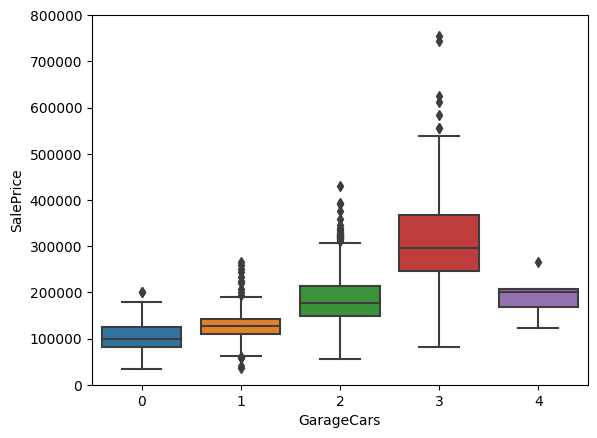

In [1650]:
# GarageCars vs Sale Price
# Size of garage in car capacity
GarageCars_data = pd.concat([train['SalePrice'], train["GarageCars"]], axis=1)
GarageCars_graph = sns.boxplot(x="GarageCars", y="SalePrice", data=GarageCars_data)
GarageCars_graph.axis(ymin=0, ymax=800000);

Theoretically, the larger the size of garage, the more expensive the house is. In this case, 4-car garages costing less is nonsensical. 

<Axes: xlabel='GarageCars', ylabel='SalePrice'>

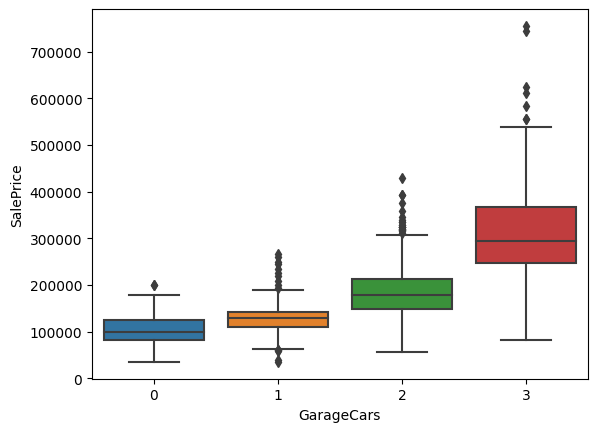

In [1651]:
# Removing outliers whose values are more than 4-cars and less than $300k
drop_contidion = (train['GarageCars']>3) & (train['SalePrice']<300000)
train = train.drop(train[drop_contidion].index).reset_index(drop=True) # use the drop parameter to avoid the old index being added as a column

# Re-graphing "GarageCars"
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

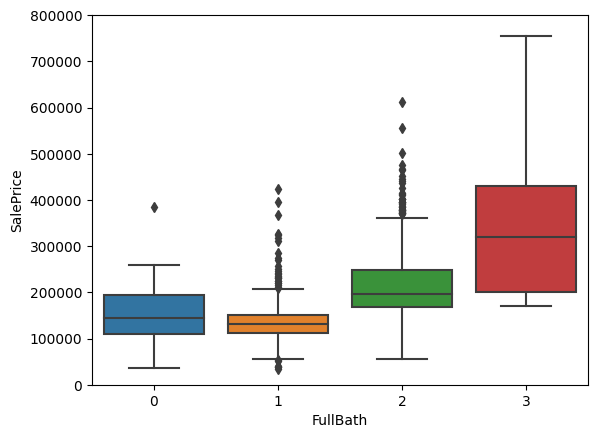

In [1652]:
# FullBath vs Sale Price
# Full bathrooms above grade
FullBath_data = pd.concat([train['FullBath'], train["SalePrice"]], axis=1)
FullBath_graph = sns.boxplot(x="FullBath", y="SalePrice", data=FullBath_data)
FullBath_graph.axis(ymin=0, ymax=800000);

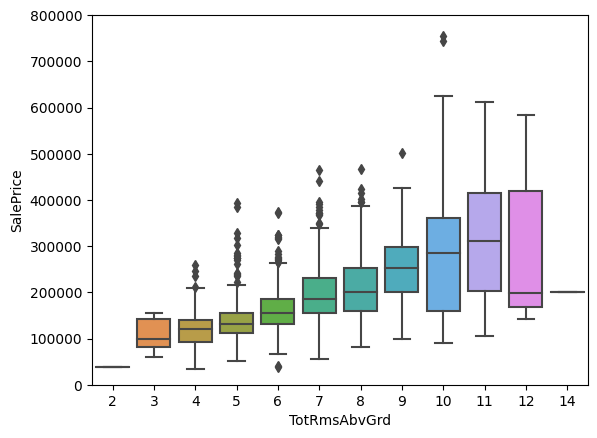

In [1653]:
# TotRmsAbvGrd and SalePrice Total Rooms
TotRmsAbvGrd_data = pd.concat([train['TotRmsAbvGrd'], train["SalePrice"]], axis=1)
TotRmsAbvGrd_graph = sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=TotRmsAbvGrd_data)
TotRmsAbvGrd_graph.axis(ymin=0, ymax=800000);

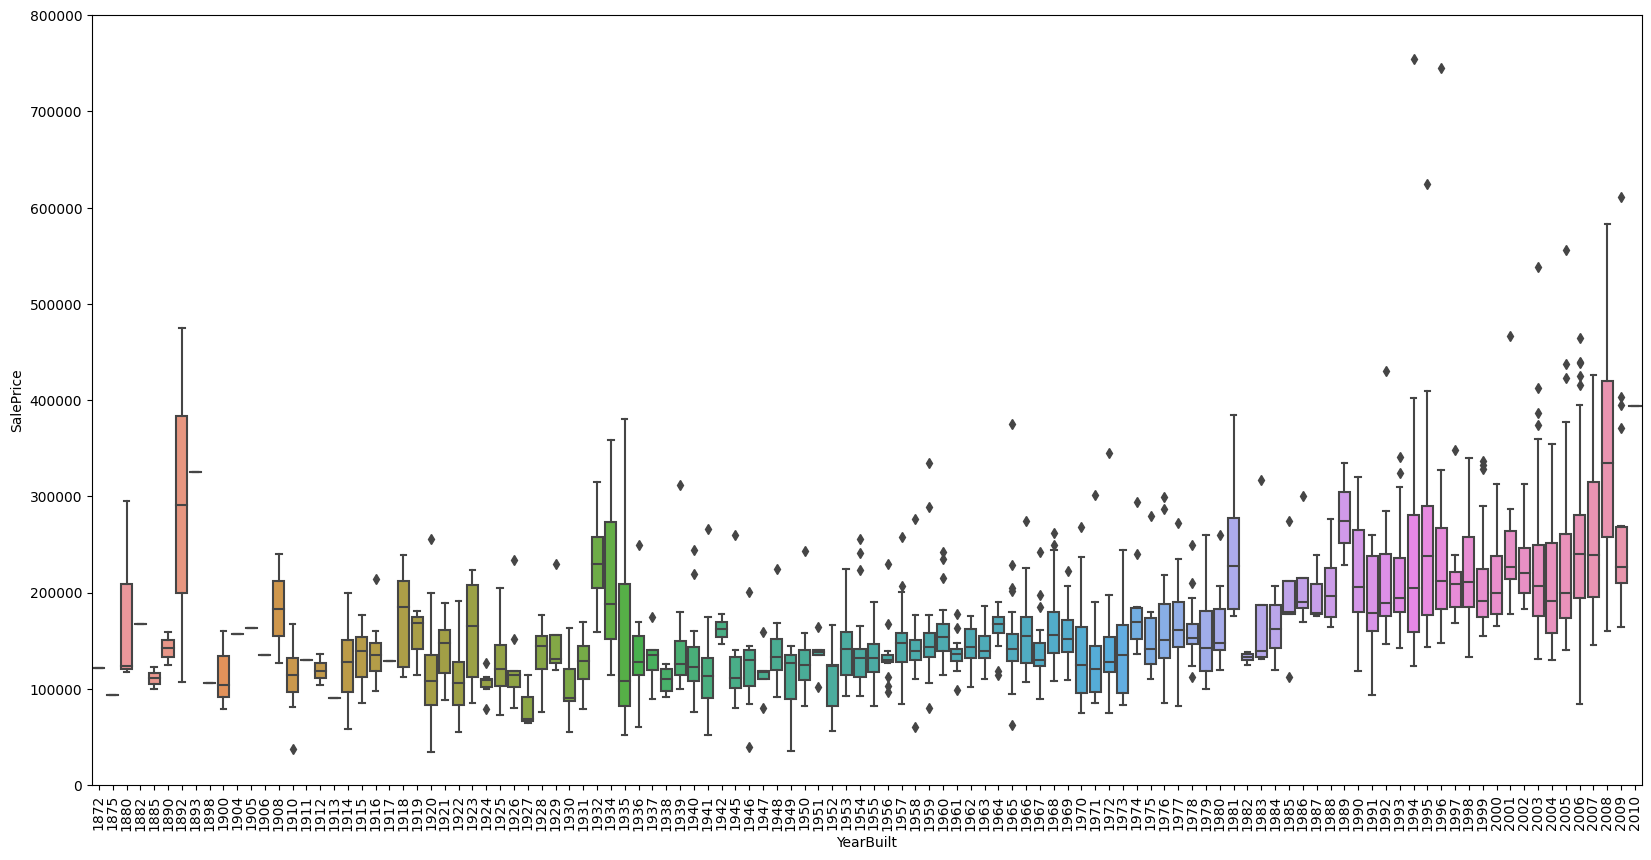

In [1654]:
# Year Built and Sale Price relationship uses blox plot also. 
# However, there are years that the house price was affted by the financial state of the market at that time
YearBuilt_data = pd.concat([train['SalePrice'], train["YearBuilt"]], axis=1)
plt.subplots(figsize=(20, 10))
YearBuilt_graph = sns.boxplot(x="YearBuilt", y="SalePrice", data=YearBuilt_data)
YearBuilt_graph.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

### Scatter Plots

Value of r is: 0.71
Value of p is:  6.970170621319098e-223


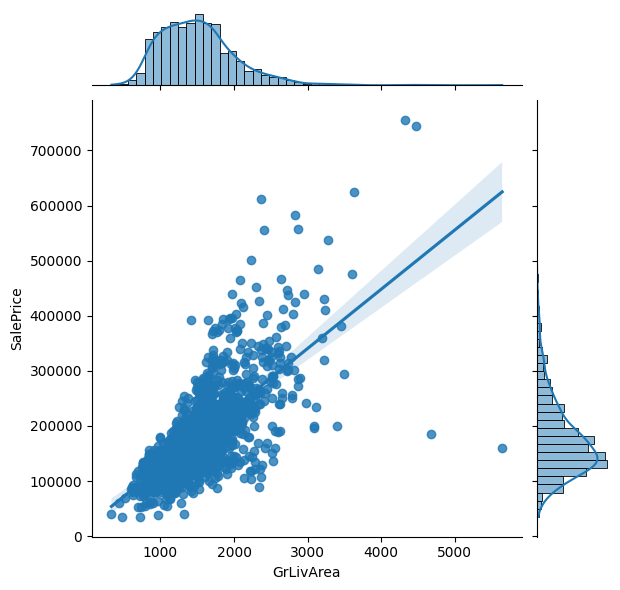

In [1655]:
# Ground Living Area and vs Sale Price
( r, p ) = stats.pearsonr(x=train['GrLivArea'], y=train['SalePrice'])
print("Value of r is: {:.2f}".format(r))
print("Value of p is: ", p)
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Data seems fine except the two data points located at the bottom right corner since the living area should be proportional to the sale price. 

Value of r is: 0.74
Value of p is:  6.114673402715463e-248


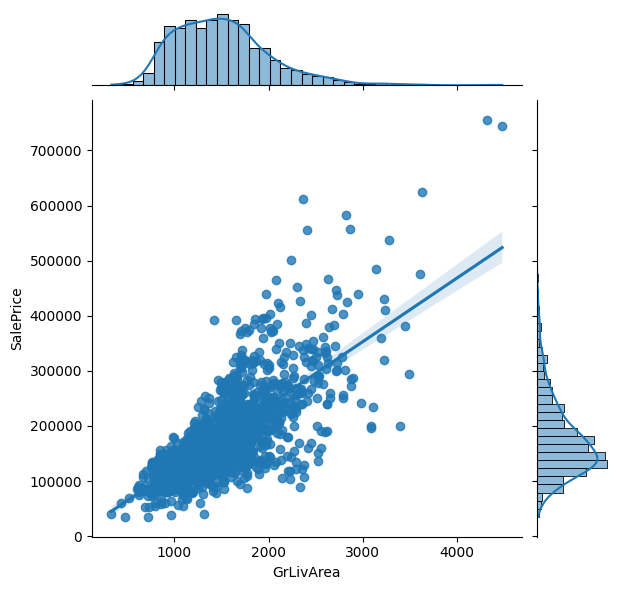

In [1656]:
drop_contidion = ( train["GrLivArea"] > 4000) & ( train["SalePrice"] <250000)
train = train.drop(train[drop_contidion].index).reset_index(drop=True)

# Re-graphing "GrLivArea"
( r, p ) = stats.pearsonr(x=train['GrLivArea'], y=train['SalePrice'])
print("Value of r is: {:.2f}".format(r))
print("Value of p is: ", p)
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Value of r is: 0.63
Value of p is:  2.319481177366708e-164


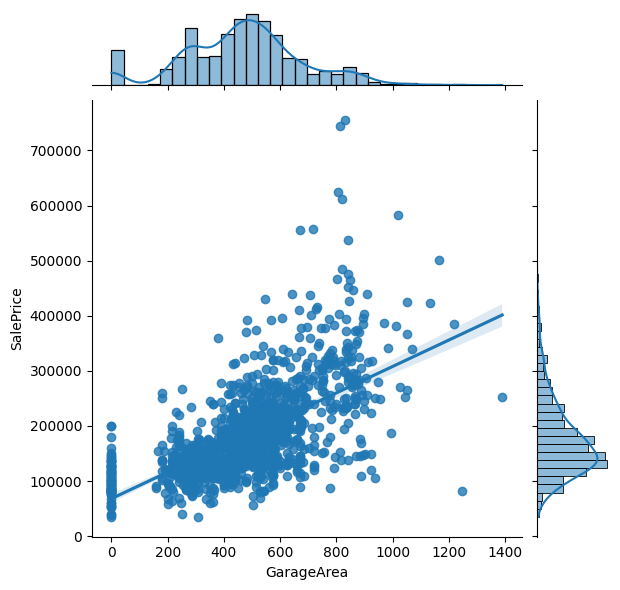

In [1657]:
# Garage Area and Sale Price
( r, p ) = stats.pearsonr(x=train['GarageArea'], y=train['SalePrice'])
print("Value of r is: {:.2f}".format(r))
print("Value of p is: ", p)
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

Again, there are two outliers need removing residing at the bottom right corner

Value of r is: 0.64
Value of p is:  9.427045151438416e-170


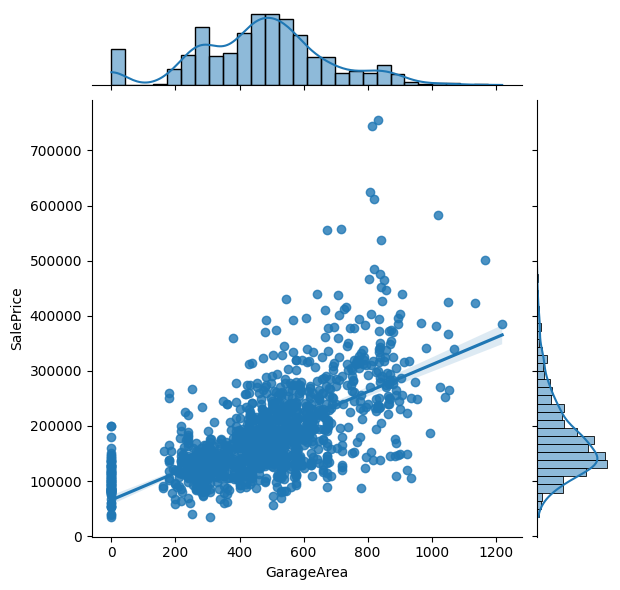

In [1658]:
drop_contidion = ( train["GarageArea"] > 1200) & ( train["SalePrice"] <300000)
train = train.drop(train[drop_contidion].index).reset_index(drop=True)

# Re-graphing "GrLivArea"
( r, p ) = stats.pearsonr(x=train['GarageArea'], y=train['SalePrice'])
print("Value of r is: {:.2f}".format(r))
print("Value of p is: ", p)
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

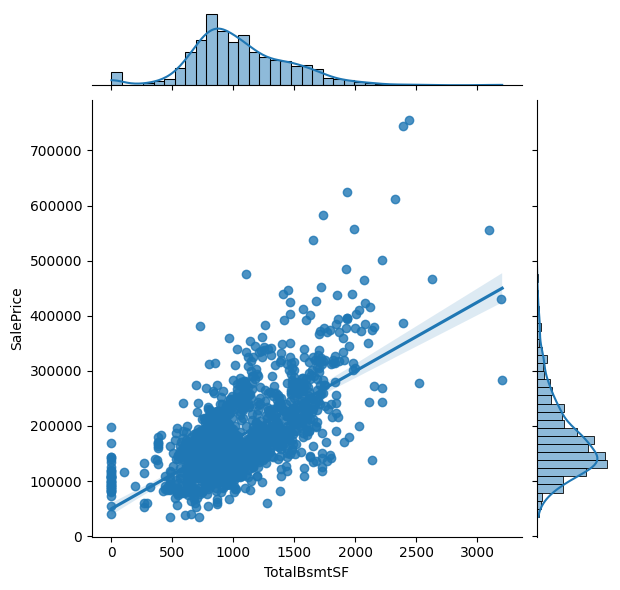

In [1659]:
# Total square feet of basement area and Sale Price 
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

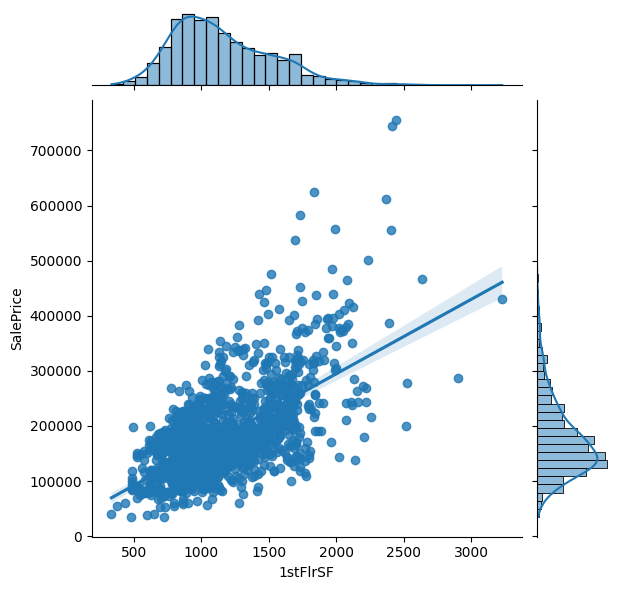

In [1660]:
#  First Floor square feet Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

In [1661]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']


In [1662]:
print("Before log transformation: \n");
display(pd.DataFrame(train["SalePrice"]))

# Log transformation 
log_train = train
log_train["SalePrice"] = np.log1p(log_train["SalePrice"])
print("After log transformation: \n");
display(pd.DataFrame(train["SalePrice"]))


Before log transformation: 



,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1446,175000
1447,210000
1448,266500
1449,142125


After log transformation: 



,SalePrice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220
...,...
1446,12.072547
1447,12.254868
1448,12.493133
1449,11.864469


- From the previous distribution of the "SlaePrice" column, we realized that the distribution is right-skewed and the data is not normally distributed. To fix this, we can apply a certain technique to compress it. And the one will be used is "Log Transformation".

            -> y = log(x)
            
    where: 

            x : input data

            y: transformed data

            base of logarithm : usually "2","10", or "e"


Since we applied the Log Tranformation, the "SalePrice" columns from now on should be consider based on "log" scale. 

Value of mean is : 12.02
Value of Standard Deviation is: 0.40


C:\Users\HP\AppData\Local\Temp\ipykernel_21284\3261692600.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_train['SalePrice'] , fit=norm);


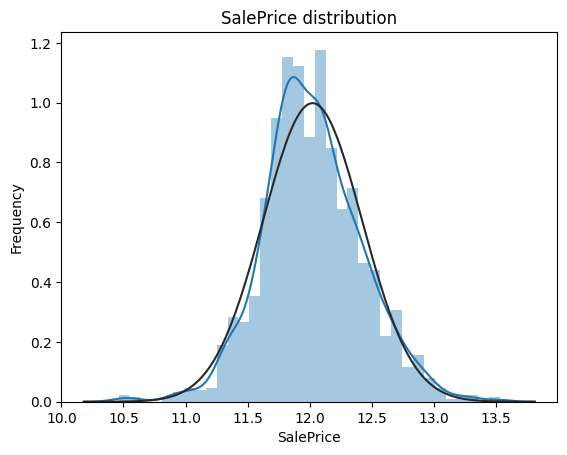

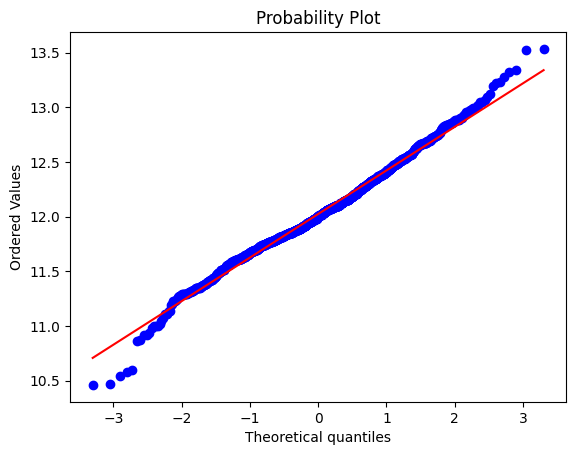

Value of Skewness is : 0.125807
Value of Kurtosis is : 0.812527


In [1663]:
# Graph the new distribution 
sns.distplot(log_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
( mean, std ) = norm.fit(log_train['SalePrice']);
print("Value of mean is : {:.2f}".format(mean))
print("Value of Standard Deviation is: {:.2f}".format(std))
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(log_train['SalePrice'], plot=plt)
plt.show()

y_train = log_train.SalePrice.values

print("Value of Skewness is : %f" % log_train['SalePrice'].skew())
print("Value of Kurtosis is : %f" % log_train['SalePrice'].kurt())

Seems like we have much better normal distribution as a result of taking the logarithm transformation. We no longer have a large right-skewed graph as earlier.

Warning : The "distplot" will be depredecated in future update so "histplot" is reccommended to be used. 

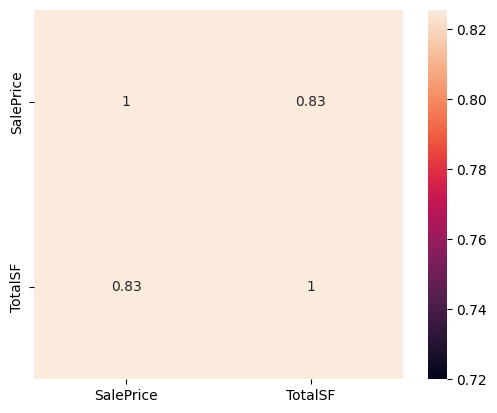

In [1664]:
# Graph the new correlation heatmap between TotalSF and SalePrice.
TotalSF_corr_index = ["SalePrice","TotalSF"]
TotalSF_corr = train[TotalSF_corr_index]
TotalSF_corr_map = TotalSF_corr.corr()
sns.heatmap(TotalSF_corr_map, vmax=.8, square=True, annot=True);



TotalSF feature scores pretty high and indeed we could add it to out top important features to be used.

In [1665]:
# COnstructing new important features
new_fetures = list(feature_column)
new_fetures.append("TotalSF")
feature_log_train = log_train[new_fetures]
feature_log_train

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,TotalSF
0,12.247699,7,1710,2,548,856,856,2,8,2003,2566
1,12.109016,6,1262,2,460,1262,1262,2,6,1976,2524
2,12.317171,7,1786,2,608,920,920,2,6,2001,2706
3,11.849405,7,1717,3,642,756,961,1,7,1915,2473
4,12.429220,8,2198,3,836,1145,1145,2,9,2000,3343
...,...,...,...,...,...,...,...,...,...,...,...
1446,12.072547,6,1647,2,460,953,953,2,7,1999,2600
1447,12.254868,6,2073,2,500,1542,2073,2,7,1978,3615
1448,12.493133,7,2340,1,252,1152,1188,2,9,1941,3492
1449,11.864469,5,1078,1,240,1078,1078,1,5,1950,2156


# Fix the skweness of other features

Unlike "SalePrice", the majority of other features are largely skewed. To fix this, we can use Box Cox Transformation

Since our considered values are positive, we have a formula:

If lambda = 0   =>  y = log(x) 

If lambda != 0  =>  y= (( x^lambda ) - 1) / lambda 

In [1666]:
abs_skewed_features = feature_log_train.apply(lambda x : abs(skew(x)))
skewed_features = feature_log_train.apply(lambda x : (skew(x)))


abs_skewness_table = pd.DataFrame({'Absolute Skewed Features' : abs_skewed_features})
skewness_table = pd.DataFrame({'Skewed Features' : skewed_features})

skewness = abs_skewness_table[abs_skewness_table > 0.75].dropna() # 0.75 is commonly used to identify significant skewness.
display(skewness_table)
print("\n Absolute skewed values to be transformed")
display(skewness)
print("There are {} skewed features that need Box Cox transform \n".format(skewness.shape[0]))
for feat in skewness.index:
    feature_log_train.loc[:, feat] = boxcox1p(feature_log_train[feat], 0.15)
    feature_log_train.loc[:, feat] += 1

,Skewed Features
SalePrice,0.125677
OverallQual,0.206698
GrLivArea,1.015076
GarageCars,-0.424384
GarageArea,0.013826
TotalBsmtSF,0.511574
1stFlrSF,0.889927
FullBath,0.029740
TotRmsAbvGrd,0.651130
YearBuilt,-0.605035



 Absolute skewed values to be transformed


,Absolute Skewed Features
GrLivArea,1.015076
1stFlrSF,0.889927
TotalSF,0.808937


There are 3 skewed features that need Box Cox transform 



In [1667]:
print("New skewness of GrLivArea", skew(feature_log_train["GrLivArea"]))
print("New skewness of 1stFlrSF", skew(feature_log_train["1stFlrSF"]))
print("New skewness of TotalSF", skew(feature_log_train["TotalSF"]))

New skewness of GrLivArea 0.08175830871514679
New skewness of 1stFlrSF 0.1402777463172972
New skewness of TotalSF -0.24803621711450705


# Constructing values for the model

In [1668]:
X_train = feature_log_train.drop("SalePrice",axis=1) # Box-Cox
Y_train = pd.DataFrame(feature_log_train["SalePrice"]) # Logarithm

display(X_train)
display(Y_train)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,TotalSF
0,7,14.698888,2,548,856,12.692623,2,8,2003,15.976591
1,6,13.792276,2,460,1262,13.792276,2,6,1976,15.923100
2,7,14.832085,2,608,920,12.892039,2,6,2001,16.149678
3,7,14.711364,3,642,756,13.013683,1,7,1915,15.857121
4,8,15.480029,3,836,1145,13.510588,2,9,2000,16.852312
...,...,...,...,...,...,...,...,...,...,...
1446,6,14.584606,2,460,953,12.990298,2,7,1999,16.019350
1447,6,15.295205,2,500,1542,15.295205,2,7,1978,17.118017
1448,7,15.679454,1,252,1152,13.616840,2,9,1941,17.000045
1449,5,13.338074,1,240,1078,13.338074,1,5,1950,15.418948


,SalePrice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220
...,...
1446,12.072547
1447,12.254868
1448,12.493133
1449,11.864469


# Linear Modeling 

### Developing and Estimating Model

In [1669]:
from sklearn.linear_model import Lasso , LinearRegression
from sklearn import model_selection   
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
def  root_mean_squared_error(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

linear_regression =  make_pipeline(RobustScaler(), LinearRegression())
lasso_regression = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

linear_regression_score = root_mean_squared_error(linear_regression)
lasso_score = root_mean_squared_error(lasso_regression)

print("\n Linear Regression score: \n Mean: {:.4f}\n Std: {:.4f}\n".format(linear_regression_score.mean(), linear_regression_score.std()))
print("\nLasso score: \n Mean: {:.4f}\n Std: {:.4f}\n".format(lasso_score.mean(), lasso_score.std()))


 Linear Regression score: 
 Mean: 0.1562
 Std: 0.0051


Lasso score: 
 Mean: 0.1561
 Std: 0.0049



### Giving prediction

In [1670]:
test = pd.read_csv("./test.csv")

test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

test_features = list(feature_column)
test_features.remove("SalePrice")
test_features.append("TotalSF")

X_test = test[test_features]

# spotting nissing value
print(X_test.isnull().sum())

X_test = X_test.dropna()


OverallQual     0
GrLivArea       0
GarageCars      1
GarageArea      1
TotalBsmtSF     1
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
TotalSF         1
dtype: int64


In [1671]:
test_abs_skewed_features = X_test.apply(lambda x : abs(skew(x)))
test_skewed_features = X_test.apply(lambda x : (skew(x)))


test_abs_skewness_table = pd.DataFrame({'Absolute Skewed Features' : test_abs_skewed_features})
test_skewness_table = pd.DataFrame({'Skewed Features' : test_skewed_features})

test_skewness = test_abs_skewness_table[test_abs_skewness_table > 0.75].dropna() # 0.75 is commonly used to identify significant skewness.
display(test_skewness_table)
print("\n Absolute skewed values to be transformed")
display(test_skewness)
print("There are {} skewed features that need Box Cox transform \n".format(test_skewness.shape[0]))


,Skewed Features
OverallQual,0.179227
GrLivArea,1.130700
GarageCars,-0.108474
GarageArea,0.298723
TotalBsmtSF,0.811804
1stFlrSF,1.554520
FullBath,0.295739
TotRmsAbvGrd,0.842324
YearBuilt,-0.590433
TotalSF,1.213599



 Absolute skewed values to be transformed


,Absolute Skewed Features
GrLivArea,1.130700
TotalBsmtSF,0.811804
1stFlrSF,1.554520
TotRmsAbvGrd,0.842324
TotalSF,1.213599


There are 5 skewed features that need Box Cox transform 



In [1672]:
# Box-Cox Transformation
for feat in test_skewness.index:
    X_test.loc[:, feat] = boxcox1p(X_test[feat], 0.15)
    X_test.loc[:, feat] += 1

In [1673]:

# Giving prediction
lasso_regression.fit(X_train, Y_train)
prediction = lasso_regression.predict(X_test)
X_test["SalePrice"] = prediction

# Undo Box-Cox transformation for X_test features
for feat in test_skewness.index:
    X_test.loc[:, feat] = (np.power(0.15*X_test[feat]+1, 1/0.15)) - 1
    
# If you suspect that this will not undo box-cox, please test the code below
# x = 10
# boxcox =boxcox1p(x, 0.15)
# print(boxcox)
# undo = (np.power(0.15*boxcox+1, 1/0.15)) - 1
# print(undo)

# Undo the Log Tranformation
X_test["SalePrice"] = np.expm1(X_test["SalePrice"])

display(X_test)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,TotalSF,SalePrice
0,5,1273.469232,1.0,730.0,1254.592224,1273.469232,1,11.370985,1961,2443.399233,117886.307931
1,6,1851.897598,1.0,312.0,1851.897598,1851.897598,1,13.208105,1958,3586.730962,150160.847059
2,5,2247.863187,2.0,482.0,1316.568805,1316.568805,2,13.208105,1997,3456.348153,158901.788048
3,6,2214.986857,2.0,470.0,1313.876996,1313.876996,2,15.022793,1998,3421.460931,173400.117228
4,8,1786.895018,2.0,506.0,1786.895018,1786.895018,2,11.370985,1992,3460.223654,200786.575157
...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1536.495073,0.0,0.0,796.893372,796.893372,1,11.370985,1970,2259.693703,92915.496676
1455,4,1536.495073,1.0,286.0,796.893372,796.893372,1,13.208105,1970,2259.693703,100288.429531
1456,5,1712.479699,2.0,576.0,1712.479699,1712.479699,1,15.022793,1960,3315.420561,140347.382256
1457,5,1373.039659,0.0,0.0,1295.027236,1373.039659,1,13.208105,1992,2579.493183,112536.287440
